In [1]:
%matplotlib inline


# Effect of transforming the targets in regression model


In this example, we give an overview of the
:class:`sklearn.compose.TransformedTargetRegressor`. Two examples
illustrate the benefit of transforming the targets before learning a linear
regression model. The first example uses synthetic data while the second
example is based on the Boston housing data set.


In [2]:
# Author: Guillaume Lemaitre <guillaume.lemaitre@inria.fr>
# License: BSD 3 clause


import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion

print(__doc__)

Automatically created module for IPython interactive environment


Synthetic example
##############################################################################



In [3]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score


# `normed` is being deprecated in favor of `density` in histograms
if LooseVersion(matplotlib.__version__) >= '2.1':
    density_param = {'density': True}
else:
    density_param = {'normed': True}

A synthetic random regression problem is generated. The targets ``y`` are
modified by: (i) translating all targets such that all entries are
non-negative and (ii) applying an exponential function to obtain non-linear
targets which cannot be fitted using a simple linear model.

Therefore, a logarithmic (`np.log1p`) and an exponential function
(`np.expm1`) will be used to transform the targets before training a linear
regression model and using it for prediction.



In [5]:
X, y = make_regression(n_samples=10000, noise=100, random_state=0)
y = np.exp((y + abs(y.min())) / 200)
y_trans = np.log1p(y)

The following illustrate the probability density functions of the target
before and after applying the logarithmic functions.



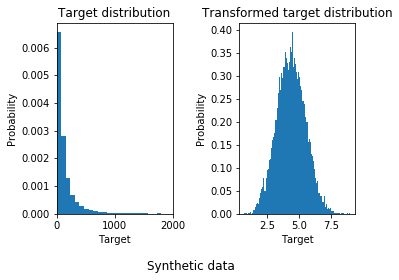

In [6]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, **density_param)
ax0.set_xlim([0, 2000])
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.set_title('Target distribution')

ax1.hist(y_trans, bins=100, **density_param)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.set_title('Transformed target distribution')

f.suptitle("Synthetic data", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

At first, a linear model will be applied on the original targets. Due to the
non-linearity, the model trained will not be precise during the
prediction. Subsequently, a logarithmic function is used to linearize the
targets, allowing better prediction even with a similar linear model as
reported by the median absolute error (MAE).



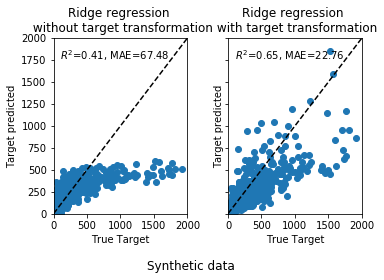

In [7]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

ax0.scatter(y_test, y_pred)
ax0.plot([0, 2000], [0, 2000], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(100, 1750, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax0.set_xlim([0, 2000])
ax0.set_ylim([0, 2000])

regr_trans = TransformedTargetRegressor(regressor=RidgeCV(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)

ax1.scatter(y_test, y_pred)
ax1.plot([0, 2000], [0, 2000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(100, 1750, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax1.set_xlim([0, 2000])
ax1.set_ylim([0, 2000])

f.suptitle("Synthetic data", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

Real-world data set
##############################################################################



In a similar manner, the boston housing data set is used to show the impact
of transforming the targets before learning a model. In this example, the
targets to be predicted corresponds to the weighted distances to the five
Boston employment centers.



In [11]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import QuantileTransformer, quantile_transform

dataset = load_boston()
target = np.array(dataset.feature_names) == "DIS"
X = dataset.data[:, np.logical_not(target)]
y = dataset.data[:, target].squeeze()
y_trans = quantile_transform(dataset.data[:, target],
                             n_quantiles=300,
                             output_distribution='normal',
                             copy=True).squeeze()

A :class:`sklearn.preprocessing.QuantileTransformer` is used such that the
targets follows a normal distribution before applying a
:class:`sklearn.linear_model.RidgeCV` model.



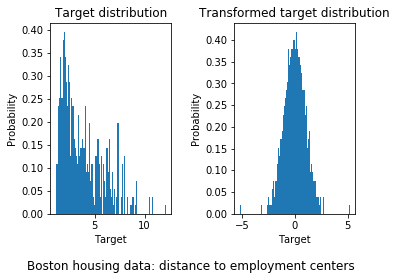

In [12]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, **density_param)
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.set_title('Target distribution')

ax1.hist(y_trans, bins=100, **density_param)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.set_title('Transformed target distribution')

f.suptitle("Boston housing data: distance to employment centers", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

The effect of the transformer is weaker than on the synthetic data. However,
the transform induces a decrease of the MAE.



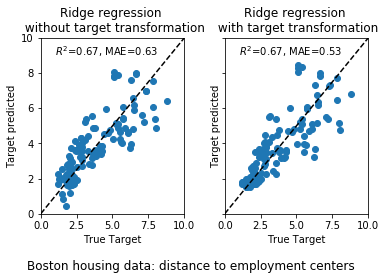

In [10]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

ax0.scatter(y_test, y_pred)
ax0.plot([0, 10], [0, 10], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(1, 9, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax0.set_xlim([0, 10])
ax0.set_ylim([0, 10])

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)

ax1.scatter(y_test, y_pred)
ax1.plot([0, 10], [0, 10], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 9, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax1.set_xlim([0, 10])
ax1.set_ylim([0, 10])

f.suptitle("Boston housing data: distance to employment centers", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()